In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time
from tqdm import tqdm
import wandb
import wandb.sdk.wandb_settings as wandb_settings
from tensorflow.keras.datasets import mnist
from sklearn.metrics import auc, precision_recall_fscore_support, roc_curve, precision_recall_curve, f1_score
import gc 


/home/detour/anaconda3/envs/smai/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/detour/anaconda3/envs/smai/lib/python3.13/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because

In [2]:
class Activation:
    """Base class for activation functions."""
    def forward(self, x):
        raise NotImplementedError
    
    def backward(self, grad_output):
        raise NotImplementedError
        
    def __str__(self):
        return self.__class__.__name__

class Identity(Activation):
    """Identity activation function (no activation)."""
    def forward(self, x):
        self.input = x
        return x
    
    def backward(self, grad_output):
        return grad_output

class ReLU(Activation):
    """ReLU activation function."""
    def forward(self, x):
        self.input = x
        return np.maximum(0, x)
    
    def backward(self, grad_output):
        return grad_output * (self.input > 0)

class Tanh(Activation):
    """Tanh activation function."""
    def forward(self, x):
        self.output = np.tanh(x)
        return self.output
    
    def backward(self, grad_output):
        return grad_output * (1 - self.output**2)

class Sigmoid(Activation):
    """Sigmoid activation function."""
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-x))
        return self.output
    
    def backward(self, grad_output):
        return grad_output * (self.output * (1 - self.output))

In [3]:
class Linear:
    """  Fully connected linear layer with activation function."""
    def __init__(self, input_dim, output_dim, activation=Identity()):
        self.input_dim = input_dim
        self.output_dim = output_dim
        if isinstance(activation, ReLU):
            limit = np.sqrt(6 / (input_dim))
        else:
            limit = np.sqrt(6 / (input_dim + output_dim))
        self.activation = activation
        self.weights = np.random.uniform(-limit, limit, (input_dim, output_dim))
        self.biases = np.zeros((1, output_dim))
        self.input = None
        self.output = None   
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.zeros_like(self.biases)
    
    def forward(self, x):
        """ Forward pass """
        self.input = x
        pre_activation = x @ self.weights + self.biases
        self.output = self.activation.forward(pre_activation)
        return self.output
    
    def backward(self, grad_output):
        """ Backward pass """
        grad_pre_activation = self.activation.backward(grad_output)
        self.grad_weights += self.input.T @ grad_pre_activation
        self.grad_biases += np.sum(grad_pre_activation, axis=0, keepdims=True)
        grad_input = grad_pre_activation @ self.weights.T
        return grad_input

    def update(self, learning_rate):
        """Update parameters using accumulated gradients"""
        self.weights -= learning_rate * self.grad_weights
        self.biases -= learning_rate * self.grad_biases

    def zero_grad(self):
        """Reset accumulated gradients to zero"""
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.zeros_like(self.biases)

    def get_params(self):
        """Returns the layer's parameters in a dictionary."""
        return {'weights': self.weights, 'biases': self.biases}

    def set_params(self, params):
        """Sets the layer's parameters from a dictionary."""
        self.weights = params['weights']
        self.biases = params['biases']
    
    def set_parameters_dtype(self, dtype):
        """Casts the weights and biases to a specified data type."""
        self.weights = self.weights.astype(dtype)
        self.biases = self.biases.astype(dtype)

In [4]:
class Loss:
    """Base class for loss functions."""
    def forward(self, y_pred, y_true):
        raise NotImplementedError
        
    def backward(self, y_pred, y_true):
        raise NotImplementedError

class MSE(Loss):
    """Mean Squared Error Loss."""
    def forward(self, y_pred, y_true):
        return np.mean((y_pred - y_true)**2)
    
    def backward(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.shape[0]

class BCE(Loss):
    """Binary Cross Entropy Loss."""
    def forward(self, y_pred, y_true):
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def backward(self, y_pred, y_true):
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return (y_pred - y_true) / (y_pred * (1 - y_pred)) / y_true.shape[0]

In [5]:
class Model:
    """A neural network model composed of a list of layers."""
    def __init__(self, layers, loss_fn):
        self.layers = layers
        self.loss_fn = loss_fn

    def forward(self, x):
        """Sequentially execute the forward pass in each layer."""
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, grad):
        """Sequentially execute the backward pass in reverse order."""
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad

    def train(self, x, y):
        """Perform a single training step: forward, loss, backward."""
        y_pred = self.forward(x)
        loss = self.loss_fn.forward(y_pred, y)
        initial_grad = self.loss_fn.backward(y_pred, y)
        self.backward(initial_grad)
        return loss

    def zero_grad(self):
        """Reset gradients in all layers to zero."""
        for layer in self.layers:
            layer.zero_grad()

    def update(self, learning_rate):
        """Update parameters in all layers and then zero the gradients."""
        for layer in self.layers:
            layer.update(learning_rate)
        self.zero_grad()

    def predict(self, x):
        """Perform a forward pass to get a prediction."""
        return self.forward(x)
    
    def get_parameters(self):
        """ Gets a list of all parameters (weights and biases) from all layers. """
        return [layer.get_params() for layer in self.layers]
    
    def set_parameters_dtype(self, dtype):
        """Casts the parameters of all layers to a specified data type."""
        for layer in self.layers:
            layer.set_parameters_dtype(dtype)

    def set_parameters(self, params_list):
        """ Sets the parameters for all layers from a provided list. """
        if len(params_list) != len(self.layers):
            raise ValueError("The number of parameter sets must match the number of layers.")
        for layer, params in zip(self.layers, params_list):
            layer.set_params(params)

    def save_to(self, path):
        """Save all model parameters to a .npz file."""
        params = {f'layer_{i}_{k}': v for i, l in enumerate(self.layers) 
                  for k, v in l.get_params().items()}
        np.savez(path, **params)
        return

    def load_from(self, path):
        """Load model parameters from a .npz file."""
        data = np.load(path)
        for i, layer in enumerate(self.layers):
            weights = data[f'layer_{i}_weights']
            biases = data[f'layer_{i}_biases']
            
            if weights.shape != layer.weights.shape or biases.shape != layer.biases.shape:
                raise ValueError(
                    f"Shape mismatch in layer {i}. Expected weights {layer.weights.shape} "
                    f"and biases {layer.biases.shape}, but got {weights.shape} and {biases.shape}."
                )
            layer.set_params({'weights': weights, 'biases': biases})
        return

In [6]:
class MLPAutoencoder:
    """
    An MLP-based Autoencoder built using the existing Model class."""
    def __init__(self, input_dim, latent_dim, hidden_dims):
        encoder_layers = []
        last_dim = input_dim
        for h_dim in hidden_dims:
            encoder_layers.append(Linear(last_dim, h_dim, ReLU()))
            last_dim = h_dim
        encoder_layers.append(Linear(last_dim, latent_dim, ReLU()))
        self.encoder = Model(layers=encoder_layers, loss_fn=MSE())
        decoder_layers = []
        last_dim = latent_dim
        for h_dim in reversed(hidden_dims):
            decoder_layers.append(Linear(last_dim, h_dim, ReLU()))
            last_dim = h_dim
        decoder_layers.append(Linear(last_dim, input_dim, Sigmoid()))
        self.decoder = Model(layers=decoder_layers, loss_fn=MSE())
        
    def forward(self, x):
        """A full forward pass: input -> latent space -> reconstruction.""" 
        latent_representation = self.encoder.forward(x)
        reconstructed_x = self.decoder.forward(latent_representation)
        return reconstructed_x

    def train_step(self, x, learning_rate):
        """ Performs a single, complete training step: forward, loss, backward, and update. """
        reconstructed_x = self.forward(x)
        loss = self.decoder.loss_fn.forward(reconstructed_x, x)
        grad = self.decoder.loss_fn.backward(reconstructed_x, x)
        grad = self.decoder.backward(grad)
        self.encoder.backward(grad)
        self.encoder.update(learning_rate)
        self.decoder.update(learning_rate)
        return loss

In [7]:
class AutoencoderTrainer:
    """ Handles the training and evaluation of the MLPAutoencoder on the MNIST dataset."""
    def __init__(self, autoencoder, config,username):
        self.autoencoder = autoencoder
        self.config = config
        self._load_data()
        self.username = username

    def _load_data(self):
        """Loads and preprocesses the MNIST dataset."""
        (X_train_raw, _), (X_test_raw, y_test_raw) = mnist.load_data()
        self.X_train = X_train_raw.reshape(-1, 28*28).astype('float32') / 255.0
        self.X_test = X_test_raw.reshape(-1, 28*28).astype('float32') / 255.0
        self.y_test_raw = y_test_raw

    def train(self):
        """Training loop for the autoencoder."""
        for epoch in range(self.config["epochs"]):
            epoch_loss = 0
            pbar = tqdm(range(0, len(self.X_train), self.config["batch_size"]), 
                        desc=f"Epoch {epoch+1}/{self.config['epochs']}")
            
            for i in pbar:
                x_batch = self.X_train[i : i + self.config["batch_size"]]
                loss = self.autoencoder.train_step(x_batch, self.config["learning_rate"])
                epoch_loss += loss
                pbar.set_postfix({"loss": f"{loss:.4f}"})

            avg_loss = epoch_loss / (len(self.X_train) / self.config["batch_size"])
            print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")
        return 
    
    
    def _watermark(self, ax):
        """Adds a watermark to the plot axis."""
        ax.text(0.98, 0.98, self.username, ha='right', va='top', 
        transform=ax.transAxes, fontsize=10, color='black', alpha=0.6)

    def visualize_results(self):
        """ Visualizes the performance by comparing original vs. reconstructed images."""
        fig, axes = plt.subplots(2, 10, figsize=(15, 4))
        fig.suptitle("Original vs. Reconstructed Images", fontsize=16)
        
        digit_images = []
        for i in range(10):
            idx = np.where(self.y_test_raw == i)[0][0]
            digit_images.append(self.X_test[idx])

        for i, image in enumerate(digit_images):
            reconstruction = self.autoencoder.forward(image.reshape(1, -1))
            ax_orig = axes[0, i]
            ax_orig.imshow(image.reshape(28, 28), cmap='gray')
            ax_orig.axis('off')
            ax_recon = axes[1, i]
            ax_recon.imshow(reconstruction.reshape(28, 28), cmap='gray')
            ax_recon.axis('off')

            if i == 0:
                ax_orig.set_ylabel('Original', fontsize=12)
                ax_recon.set_ylabel('Reconstructed', fontsize=12)
            ax_orig.set_title(f"Digit: {i}")

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        self._watermark(plt.gca())
        plt.show()
        return
    
    def run_pipeline(self):
        """Runs the full training and evaluation pipeline."""
        self.train()
        self.visualize_results()
        return

Epoch 1/150: 100%|██████████| 235/235 [00:04<00:00, 49.97it/s, loss=0.0509]


Epoch 1 Average Loss: 0.0573


Epoch 2/150: 100%|██████████| 235/235 [00:04<00:00, 47.35it/s, loss=0.0391]


Epoch 2 Average Loss: 0.0370


Epoch 3/150: 100%|██████████| 235/235 [00:04<00:00, 55.40it/s, loss=0.0332]


Epoch 3 Average Loss: 0.0310


Epoch 4/150: 100%|██████████| 235/235 [00:04<00:00, 55.34it/s, loss=0.0321]


Epoch 4 Average Loss: 0.0273


Epoch 5/150: 100%|██████████| 235/235 [00:04<00:00, 55.82it/s, loss=0.0300]


Epoch 5 Average Loss: 0.0247


Epoch 6/150: 100%|██████████| 235/235 [00:04<00:00, 55.69it/s, loss=0.0260]


Epoch 6 Average Loss: 0.0228


Epoch 7/150: 100%|██████████| 235/235 [00:04<00:00, 50.48it/s, loss=0.0229]


Epoch 7 Average Loss: 0.0213


Epoch 8/150: 100%|██████████| 235/235 [00:04<00:00, 51.18it/s, loss=0.0239]


Epoch 8 Average Loss: 0.0201


Epoch 9/150: 100%|██████████| 235/235 [00:04<00:00, 49.51it/s, loss=0.0246]


Epoch 9 Average Loss: 0.0191


Epoch 10/150: 100%|██████████| 235/235 [00:04<00:00, 55.84it/s, loss=0.0218]


Epoch 10 Average Loss: 0.0183


Epoch 11/150: 100%|██████████| 235/235 [00:04<00:00, 52.45it/s, loss=0.0190]


Epoch 11 Average Loss: 0.0175


Epoch 12/150: 100%|██████████| 235/235 [00:04<00:00, 53.84it/s, loss=0.0201]


Epoch 12 Average Loss: 0.0169


Epoch 13/150: 100%|██████████| 235/235 [00:04<00:00, 54.02it/s, loss=0.0190]


Epoch 13 Average Loss: 0.0164


Epoch 14/150: 100%|██████████| 235/235 [00:04<00:00, 54.28it/s, loss=0.0198]


Epoch 14 Average Loss: 0.0159


Epoch 15/150: 100%|██████████| 235/235 [00:04<00:00, 53.53it/s, loss=0.0196]


Epoch 15 Average Loss: 0.0154


Epoch 16/150: 100%|██████████| 235/235 [00:04<00:00, 53.12it/s, loss=0.0184]


Epoch 16 Average Loss: 0.0151


Epoch 17/150: 100%|██████████| 235/235 [00:04<00:00, 55.40it/s, loss=0.0183]


Epoch 17 Average Loss: 0.0148


Epoch 18/150: 100%|██████████| 235/235 [00:04<00:00, 54.29it/s, loss=0.0214]


Epoch 18 Average Loss: 0.0145


Epoch 19/150: 100%|██████████| 235/235 [00:04<00:00, 50.32it/s, loss=0.0162]


Epoch 19 Average Loss: 0.0142


Epoch 20/150: 100%|██████████| 235/235 [00:04<00:00, 55.18it/s, loss=0.0179]


Epoch 20 Average Loss: 0.0139


Epoch 21/150: 100%|██████████| 235/235 [00:04<00:00, 54.57it/s, loss=0.0158]


Epoch 21 Average Loss: 0.0136


Epoch 22/150: 100%|██████████| 235/235 [00:04<00:00, 56.69it/s, loss=0.0153]


Epoch 22 Average Loss: 0.0135


Epoch 23/150: 100%|██████████| 235/235 [00:04<00:00, 48.11it/s, loss=0.0202]


Epoch 23 Average Loss: 0.0133


Epoch 24/150: 100%|██████████| 235/235 [00:04<00:00, 53.59it/s, loss=0.0164]


Epoch 24 Average Loss: 0.0131


Epoch 25/150: 100%|██████████| 235/235 [00:04<00:00, 52.66it/s, loss=0.0160]


Epoch 25 Average Loss: 0.0128


Epoch 26/150: 100%|██████████| 235/235 [00:04<00:00, 53.07it/s, loss=0.0174]


Epoch 26 Average Loss: 0.0127


Epoch 27/150: 100%|██████████| 235/235 [00:04<00:00, 53.28it/s, loss=0.0132]


Epoch 27 Average Loss: 0.0124


Epoch 28/150: 100%|██████████| 235/235 [00:04<00:00, 54.80it/s, loss=0.0150]


Epoch 28 Average Loss: 0.0124


Epoch 29/150: 100%|██████████| 235/235 [00:04<00:00, 53.34it/s, loss=0.0153]


Epoch 29 Average Loss: 0.0122


Epoch 30/150: 100%|██████████| 235/235 [00:04<00:00, 52.98it/s, loss=0.0152]


Epoch 30 Average Loss: 0.0121


Epoch 31/150: 100%|██████████| 235/235 [00:04<00:00, 54.67it/s, loss=0.0143]


Epoch 31 Average Loss: 0.0120


Epoch 32/150: 100%|██████████| 235/235 [00:04<00:00, 53.60it/s, loss=0.0128]


Epoch 32 Average Loss: 0.0119


Epoch 33/150: 100%|██████████| 235/235 [00:04<00:00, 52.90it/s, loss=0.0151]


Epoch 33 Average Loss: 0.0117


Epoch 34/150: 100%|██████████| 235/235 [00:04<00:00, 51.63it/s, loss=0.0153]


Epoch 34 Average Loss: 0.0116


Epoch 35/150: 100%|██████████| 235/235 [00:04<00:00, 52.79it/s, loss=0.0136]


Epoch 35 Average Loss: 0.0114


Epoch 36/150: 100%|██████████| 235/235 [00:04<00:00, 54.37it/s, loss=0.0145]


Epoch 36 Average Loss: 0.0114


Epoch 37/150: 100%|██████████| 235/235 [00:04<00:00, 52.41it/s, loss=0.0164]


Epoch 37 Average Loss: 0.0113


Epoch 38/150: 100%|██████████| 235/235 [00:04<00:00, 51.81it/s, loss=0.0160]


Epoch 38 Average Loss: 0.0112


Epoch 39/150: 100%|██████████| 235/235 [00:04<00:00, 53.55it/s, loss=0.0139]


Epoch 39 Average Loss: 0.0111


Epoch 40/150: 100%|██████████| 235/235 [00:04<00:00, 53.86it/s, loss=0.0126]


Epoch 40 Average Loss: 0.0110


Epoch 41/150: 100%|██████████| 235/235 [00:04<00:00, 51.52it/s, loss=0.0131]


Epoch 41 Average Loss: 0.0110


Epoch 42/150: 100%|██████████| 235/235 [00:04<00:00, 50.32it/s, loss=0.0137]


Epoch 42 Average Loss: 0.0108


Epoch 43/150: 100%|██████████| 235/235 [00:04<00:00, 51.58it/s, loss=0.0124]


Epoch 43 Average Loss: 0.0109


Epoch 44/150: 100%|██████████| 235/235 [00:04<00:00, 50.62it/s, loss=0.0121]


Epoch 44 Average Loss: 0.0107


Epoch 45/150: 100%|██████████| 235/235 [00:04<00:00, 52.91it/s, loss=0.0137]


Epoch 45 Average Loss: 0.0106


Epoch 46/150: 100%|██████████| 235/235 [00:05<00:00, 45.72it/s, loss=0.0121]


Epoch 46 Average Loss: 0.0105


Epoch 47/150: 100%|██████████| 235/235 [00:04<00:00, 48.77it/s, loss=0.0131]


Epoch 47 Average Loss: 0.0105


Epoch 48/150: 100%|██████████| 235/235 [00:04<00:00, 53.10it/s, loss=0.0131]


Epoch 48 Average Loss: 0.0104


Epoch 49/150: 100%|██████████| 235/235 [00:04<00:00, 52.09it/s, loss=0.0118]


Epoch 49 Average Loss: 0.0103


Epoch 50/150: 100%|██████████| 235/235 [00:04<00:00, 52.18it/s, loss=0.0135]


Epoch 50 Average Loss: 0.0103


Epoch 51/150: 100%|██████████| 235/235 [00:04<00:00, 48.96it/s, loss=0.0118]


Epoch 51 Average Loss: 0.0103


Epoch 52/150: 100%|██████████| 235/235 [00:04<00:00, 51.79it/s, loss=0.0135]


Epoch 52 Average Loss: 0.0102


Epoch 53/150: 100%|██████████| 235/235 [00:04<00:00, 51.99it/s, loss=0.0141]


Epoch 53 Average Loss: 0.0101


Epoch 54/150: 100%|██████████| 235/235 [00:04<00:00, 52.27it/s, loss=0.0139]


Epoch 54 Average Loss: 0.0101


Epoch 55/150: 100%|██████████| 235/235 [00:04<00:00, 50.75it/s, loss=0.0129]


Epoch 55 Average Loss: 0.0100


Epoch 56/150: 100%|██████████| 235/235 [00:04<00:00, 53.32it/s, loss=0.0126]


Epoch 56 Average Loss: 0.0100


Epoch 57/150: 100%|██████████| 235/235 [00:04<00:00, 51.94it/s, loss=0.0116]


Epoch 57 Average Loss: 0.0099


Epoch 58/150: 100%|██████████| 235/235 [00:04<00:00, 51.31it/s, loss=0.0114]


Epoch 58 Average Loss: 0.0098


Epoch 59/150: 100%|██████████| 235/235 [00:04<00:00, 50.75it/s, loss=0.0118]


Epoch 59 Average Loss: 0.0098


Epoch 60/150: 100%|██████████| 235/235 [00:04<00:00, 50.18it/s, loss=0.0126]


Epoch 60 Average Loss: 0.0097


Epoch 61/150: 100%|██████████| 235/235 [00:04<00:00, 51.23it/s, loss=0.0120]


Epoch 61 Average Loss: 0.0097


Epoch 62/150: 100%|██████████| 235/235 [00:04<00:00, 50.61it/s, loss=0.0114]


Epoch 62 Average Loss: 0.0097


Epoch 63/150: 100%|██████████| 235/235 [00:04<00:00, 51.54it/s, loss=0.0116]


Epoch 63 Average Loss: 0.0096


Epoch 64/150: 100%|██████████| 235/235 [00:04<00:00, 48.79it/s, loss=0.0106]


Epoch 64 Average Loss: 0.0096


Epoch 65/150: 100%|██████████| 235/235 [00:04<00:00, 50.84it/s, loss=0.0106]


Epoch 65 Average Loss: 0.0094


Epoch 66/150: 100%|██████████| 235/235 [00:04<00:00, 50.21it/s, loss=0.0123]


Epoch 66 Average Loss: 0.0095


Epoch 67/150: 100%|██████████| 235/235 [00:04<00:00, 50.87it/s, loss=0.0104]


Epoch 67 Average Loss: 0.0094


Epoch 68/150: 100%|██████████| 235/235 [00:04<00:00, 49.19it/s, loss=0.0113]


Epoch 68 Average Loss: 0.0094


Epoch 69/150: 100%|██████████| 235/235 [00:04<00:00, 48.08it/s, loss=0.0118]


Epoch 69 Average Loss: 0.0094


Epoch 70/150: 100%|██████████| 235/235 [00:05<00:00, 44.59it/s, loss=0.0109]


Epoch 70 Average Loss: 0.0093


Epoch 71/150: 100%|██████████| 235/235 [00:05<00:00, 44.22it/s, loss=0.0115]


Epoch 71 Average Loss: 0.0092


Epoch 72/150: 100%|██████████| 235/235 [00:06<00:00, 39.04it/s, loss=0.0123]


Epoch 72 Average Loss: 0.0093


Epoch 73/150: 100%|██████████| 235/235 [00:04<00:00, 51.18it/s, loss=0.0103]


Epoch 73 Average Loss: 0.0092


Epoch 74/150: 100%|██████████| 235/235 [00:05<00:00, 46.04it/s, loss=0.0102]


Epoch 74 Average Loss: 0.0092


Epoch 75/150: 100%|██████████| 235/235 [00:04<00:00, 50.67it/s, loss=0.0113]


Epoch 75 Average Loss: 0.0091


Epoch 76/150: 100%|██████████| 235/235 [00:05<00:00, 43.57it/s, loss=0.0116]


Epoch 76 Average Loss: 0.0091


Epoch 77/150: 100%|██████████| 235/235 [00:04<00:00, 54.15it/s, loss=0.0109]


Epoch 77 Average Loss: 0.0091


Epoch 78/150: 100%|██████████| 235/235 [00:04<00:00, 57.40it/s, loss=0.0110]


Epoch 78 Average Loss: 0.0090


Epoch 79/150: 100%|██████████| 235/235 [00:04<00:00, 52.16it/s, loss=0.0105]


Epoch 79 Average Loss: 0.0090


Epoch 80/150: 100%|██████████| 235/235 [00:06<00:00, 35.99it/s, loss=0.0100]


Epoch 80 Average Loss: 0.0089


Epoch 81/150: 100%|██████████| 235/235 [00:04<00:00, 52.29it/s, loss=0.0115]


Epoch 81 Average Loss: 0.0089


Epoch 82/150: 100%|██████████| 235/235 [00:04<00:00, 51.34it/s, loss=0.0102]


Epoch 82 Average Loss: 0.0089


Epoch 83/150: 100%|██████████| 235/235 [00:04<00:00, 53.94it/s, loss=0.0103]


Epoch 83 Average Loss: 0.0089


Epoch 84/150: 100%|██████████| 235/235 [00:04<00:00, 56.05it/s, loss=0.0100]


Epoch 84 Average Loss: 0.0088


Epoch 85/150: 100%|██████████| 235/235 [00:04<00:00, 47.58it/s, loss=0.0097]


Epoch 85 Average Loss: 0.0088


Epoch 86/150: 100%|██████████| 235/235 [00:04<00:00, 50.27it/s, loss=0.0093]


Epoch 86 Average Loss: 0.0088


Epoch 87/150: 100%|██████████| 235/235 [00:04<00:00, 56.74it/s, loss=0.0108]


Epoch 87 Average Loss: 0.0088


Epoch 88/150: 100%|██████████| 235/235 [00:06<00:00, 38.21it/s, loss=0.0114]


Epoch 88 Average Loss: 0.0087


Epoch 89/150: 100%|██████████| 235/235 [00:05<00:00, 42.65it/s, loss=0.0114]


Epoch 89 Average Loss: 0.0087


Epoch 90/150: 100%|██████████| 235/235 [00:05<00:00, 40.99it/s, loss=0.0111]


Epoch 90 Average Loss: 0.0087


Epoch 91/150: 100%|██████████| 235/235 [00:05<00:00, 45.90it/s, loss=0.0094]


Epoch 91 Average Loss: 0.0086


Epoch 92/150: 100%|██████████| 235/235 [00:05<00:00, 46.22it/s, loss=0.0111]


Epoch 92 Average Loss: 0.0086


Epoch 93/150: 100%|██████████| 235/235 [00:05<00:00, 42.02it/s, loss=0.0118]


Epoch 93 Average Loss: 0.0086


Epoch 94/150: 100%|██████████| 235/235 [00:05<00:00, 39.50it/s, loss=0.0098]


Epoch 94 Average Loss: 0.0086


Epoch 95/150: 100%|██████████| 235/235 [00:06<00:00, 38.20it/s, loss=0.0104]


Epoch 95 Average Loss: 0.0086


Epoch 96/150: 100%|██████████| 235/235 [00:05<00:00, 44.39it/s, loss=0.0093]


Epoch 96 Average Loss: 0.0085


Epoch 97/150: 100%|██████████| 235/235 [00:05<00:00, 41.26it/s, loss=0.0105]


Epoch 97 Average Loss: 0.0085


Epoch 98/150: 100%|██████████| 235/235 [00:05<00:00, 43.09it/s, loss=0.0101]


Epoch 98 Average Loss: 0.0085


Epoch 99/150: 100%|██████████| 235/235 [00:05<00:00, 44.34it/s, loss=0.0093]


Epoch 99 Average Loss: 0.0084


Epoch 100/150: 100%|██████████| 235/235 [00:05<00:00, 45.05it/s, loss=0.0105]


Epoch 100 Average Loss: 0.0085


Epoch 101/150: 100%|██████████| 235/235 [00:05<00:00, 44.76it/s, loss=0.0106]


Epoch 101 Average Loss: 0.0084


Epoch 102/150: 100%|██████████| 235/235 [00:05<00:00, 42.75it/s, loss=0.0100]


Epoch 102 Average Loss: 0.0084


Epoch 103/150: 100%|██████████| 235/235 [00:05<00:00, 43.80it/s, loss=0.0095]


Epoch 103 Average Loss: 0.0083


Epoch 104/150: 100%|██████████| 235/235 [00:05<00:00, 44.67it/s, loss=0.0106]


Epoch 104 Average Loss: 0.0084


Epoch 105/150: 100%|██████████| 235/235 [00:05<00:00, 45.55it/s, loss=0.0096]


Epoch 105 Average Loss: 0.0083


Epoch 106/150: 100%|██████████| 235/235 [00:05<00:00, 43.90it/s, loss=0.0105]


Epoch 106 Average Loss: 0.0083


Epoch 107/150: 100%|██████████| 235/235 [00:05<00:00, 43.05it/s, loss=0.0097]


Epoch 107 Average Loss: 0.0083


Epoch 108/150: 100%|██████████| 235/235 [00:05<00:00, 45.48it/s, loss=0.0107]


Epoch 108 Average Loss: 0.0083


Epoch 109/150: 100%|██████████| 235/235 [00:05<00:00, 43.24it/s, loss=0.0100]


Epoch 109 Average Loss: 0.0083


Epoch 110/150: 100%|██████████| 235/235 [00:04<00:00, 48.32it/s, loss=0.0088]


Epoch 110 Average Loss: 0.0082


Epoch 111/150: 100%|██████████| 235/235 [00:04<00:00, 58.35it/s, loss=0.0087]


Epoch 111 Average Loss: 0.0082


Epoch 112/150: 100%|██████████| 235/235 [00:03<00:00, 63.87it/s, loss=0.0092]


Epoch 112 Average Loss: 0.0082


Epoch 113/150: 100%|██████████| 235/235 [00:04<00:00, 57.50it/s, loss=0.0085]


Epoch 113 Average Loss: 0.0081


Epoch 114/150: 100%|██████████| 235/235 [00:03<00:00, 61.65it/s, loss=0.0113]


Epoch 114 Average Loss: 0.0082


Epoch 115/150: 100%|██████████| 235/235 [00:03<00:00, 58.83it/s, loss=0.0085]


Epoch 115 Average Loss: 0.0081


Epoch 116/150: 100%|██████████| 235/235 [00:03<00:00, 59.86it/s, loss=0.0097]


Epoch 116 Average Loss: 0.0081


Epoch 117/150: 100%|██████████| 235/235 [00:03<00:00, 60.59it/s, loss=0.0097]


Epoch 117 Average Loss: 0.0081


Epoch 118/150: 100%|██████████| 235/235 [00:04<00:00, 56.94it/s, loss=0.0086]


Epoch 118 Average Loss: 0.0081


Epoch 119/150: 100%|██████████| 235/235 [00:03<00:00, 63.01it/s, loss=0.0096]


Epoch 119 Average Loss: 0.0081


Epoch 120/150: 100%|██████████| 235/235 [00:03<00:00, 64.03it/s, loss=0.0094]


Epoch 120 Average Loss: 0.0081


Epoch 121/150: 100%|██████████| 235/235 [00:05<00:00, 45.55it/s, loss=0.0097]


Epoch 121 Average Loss: 0.0081


Epoch 122/150: 100%|██████████| 235/235 [00:06<00:00, 37.59it/s, loss=0.0087]


Epoch 122 Average Loss: 0.0080


Epoch 123/150: 100%|██████████| 235/235 [00:05<00:00, 44.58it/s, loss=0.0097]


Epoch 123 Average Loss: 0.0080


Epoch 124/150: 100%|██████████| 235/235 [00:04<00:00, 52.28it/s, loss=0.0089]


Epoch 124 Average Loss: 0.0080


Epoch 125/150: 100%|██████████| 235/235 [00:04<00:00, 50.42it/s, loss=0.0114]


Epoch 125 Average Loss: 0.0080


Epoch 126/150: 100%|██████████| 235/235 [00:05<00:00, 43.88it/s, loss=0.0098]


Epoch 126 Average Loss: 0.0080


Epoch 127/150: 100%|██████████| 235/235 [00:05<00:00, 42.17it/s, loss=0.0082]


Epoch 127 Average Loss: 0.0079


Epoch 128/150: 100%|██████████| 235/235 [00:08<00:00, 29.12it/s, loss=0.0088]


Epoch 128 Average Loss: 0.0080


Epoch 129/150: 100%|██████████| 235/235 [00:05<00:00, 44.08it/s, loss=0.0083]


Epoch 129 Average Loss: 0.0079


Epoch 130/150: 100%|██████████| 235/235 [00:04<00:00, 51.08it/s, loss=0.0087]


Epoch 130 Average Loss: 0.0079


Epoch 131/150: 100%|██████████| 235/235 [00:04<00:00, 52.98it/s, loss=0.0093]


Epoch 131 Average Loss: 0.0079


Epoch 132/150: 100%|██████████| 235/235 [00:04<00:00, 53.35it/s, loss=0.0080]


Epoch 132 Average Loss: 0.0078


Epoch 133/150: 100%|██████████| 235/235 [00:04<00:00, 52.01it/s, loss=0.0096]


Epoch 133 Average Loss: 0.0078


Epoch 134/150: 100%|██████████| 235/235 [00:04<00:00, 49.22it/s, loss=0.0102]


Epoch 134 Average Loss: 0.0079


Epoch 135/150: 100%|██████████| 235/235 [00:04<00:00, 51.24it/s, loss=0.0094]


Epoch 135 Average Loss: 0.0079


Epoch 136/150: 100%|██████████| 235/235 [00:05<00:00, 43.18it/s, loss=0.0085]


Epoch 136 Average Loss: 0.0078


Epoch 137/150: 100%|██████████| 235/235 [00:05<00:00, 42.61it/s, loss=0.0098]


Epoch 137 Average Loss: 0.0078


Epoch 138/150: 100%|██████████| 235/235 [00:05<00:00, 44.35it/s, loss=0.0091]


Epoch 138 Average Loss: 0.0078


Epoch 139/150: 100%|██████████| 235/235 [00:04<00:00, 54.91it/s, loss=0.0099]


Epoch 139 Average Loss: 0.0078


Epoch 140/150: 100%|██████████| 235/235 [00:04<00:00, 56.08it/s, loss=0.0093]


Epoch 140 Average Loss: 0.0078


Epoch 141/150: 100%|██████████| 235/235 [00:05<00:00, 43.46it/s, loss=0.0094]


Epoch 141 Average Loss: 0.0077


Epoch 142/150: 100%|██████████| 235/235 [00:05<00:00, 45.44it/s, loss=0.0092]


Epoch 142 Average Loss: 0.0077


Epoch 143/150: 100%|██████████| 235/235 [00:06<00:00, 38.24it/s, loss=0.0091]


Epoch 143 Average Loss: 0.0077


Epoch 144/150: 100%|██████████| 235/235 [00:05<00:00, 41.29it/s, loss=0.0081]


Epoch 144 Average Loss: 0.0077


Epoch 145/150: 100%|██████████| 235/235 [00:06<00:00, 36.55it/s, loss=0.0084]


Epoch 145 Average Loss: 0.0077


Epoch 146/150: 100%|██████████| 235/235 [00:06<00:00, 33.76it/s, loss=0.0094]


Epoch 146 Average Loss: 0.0076


Epoch 147/150: 100%|██████████| 235/235 [00:05<00:00, 43.93it/s, loss=0.0092]


Epoch 147 Average Loss: 0.0077


Epoch 148/150: 100%|██████████| 235/235 [00:06<00:00, 33.84it/s, loss=0.0079]


Epoch 148 Average Loss: 0.0076


Epoch 149/150: 100%|██████████| 235/235 [00:05<00:00, 43.22it/s, loss=0.0084]


Epoch 149 Average Loss: 0.0076


Epoch 150/150: 100%|██████████| 235/235 [00:05<00:00, 42.40it/s, loss=0.0082]


Epoch 150 Average Loss: 0.0076


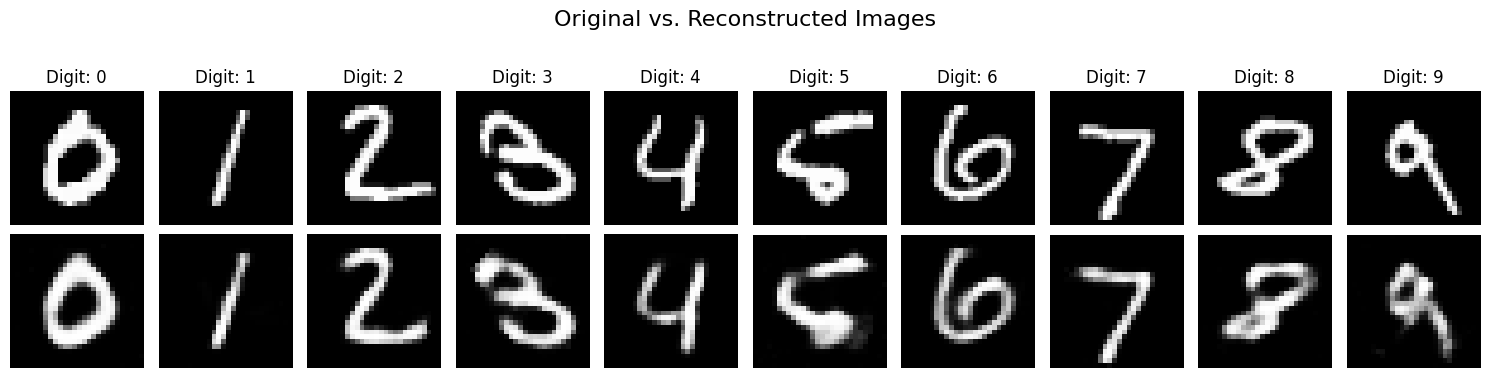

In [36]:
INPUT_DIM = 784 
LATENT_DIM = 32
HIDDEN_DIMS = [256, 128]
username = 'reddy.bathula'

config = {"learning_rate": 0.01, "epochs": 150, "batch_size": 256}
autoencoder = MLPAutoencoder(input_dim=INPUT_DIM, latent_dim=LATENT_DIM, hidden_dims=HIDDEN_DIMS)
trainer = AutoencoderTrainer(autoencoder, config, username)
trainer.run_pipeline()

## Anomoly Detection

In [ ]:
class AnomalyDetector:
    """ Handles the entire process of training and evaluating an autoencoder for anomaly detection. """
    def __init__(self, dataset_path, base_config, username='reddy.bathula'):
        self.dataset_path = dataset_path
        self.base_config = base_config
        self.best_model = None
        self.best_auc = -1
        self.best_fpr = None
        self.best_tpr = None
        self.best_thresholds = None
        self.threshold = None
        self.username = username
        self._load_data()

    def _load_data(self):
        """Private method to load and preprocess the LFW dataset from a folder structure."""
        all_images, all_labels = [], []
        normal_class_name = 'George_W_Bush'
        
        for person_name in os.listdir(self.dataset_path):
            person_folder = os.path.join(self.dataset_path, person_name)
            if not os.path.isdir(person_folder): continue
            is_normal = (person_name == normal_class_name)
            for image_filename in os.listdir(person_folder):
                try:
                    img = Image.open(os.path.join(person_folder, image_filename)).convert('L')
                    all_images.append(np.array(img))
                    all_labels.append(0 if is_normal else 1)
                except Exception:
                    continue
                    
        permutation = np.random.permutation(len(all_images))
        all_images = [all_images[i] for i in permutation]
        all_labels = [all_labels[i] for i in permutation]

        X = np.array(all_images)
        y = np.array(all_labels)
        self.image_shape = X.shape[1:]
        X_flattened = X.reshape(len(X), -1).astype('float32') / 255.0

        self.X_train_normal = X_flattened[y == 0]
        self.X_test = X_flattened
        self.y_test_anomaly = y

    def _train_model(self, autoencoder):
        """Helper method to run the training loop for a given autoencoder."""
        for epoch in range(self.base_config["epochs"]):
            pbar = tqdm(range(0, len(self.X_train_normal), self.base_config["batch_size"]),
                        desc=f"Epoch {epoch+1}/{self.base_config['epochs']}", leave=False)
            for i in pbar:
                x_batch = self.X_train_normal[i: i + self.base_config["batch_size"]]
                loss = autoencoder.train_step(x_batch, self.base_config["learning_rate"])
                pbar.set_postfix({"loss": f"{loss:.4f}"})
        gc.collect()

    def run_bottleneck_analysis(self, bottleneck_dims):
        """ Investigates how the bottleneck dimension affects performance by training a model for each dimension and plotting their ROC curves. """
        plt.figure(figsize=(8, 8))
        for latent_dim in bottleneck_dims:
            autoencoder = MLPAutoencoder(
                input_dim=self.X_test.shape[1],
                latent_dim=latent_dim,
                hidden_dims=[256, 128]
            )
            self._train_model(autoencoder)
            
            errors = self._get_reconstruction_errors(autoencoder, self.X_test)
            fpr, tpr, thresholds = roc_curve(self.y_test_anomaly, errors)
            auc_score = auc(fpr, tpr)

            if auc_score > self.best_auc:
                self.best_auc = auc_score
                self.best_model = autoencoder
                self.best_fpr = fpr
                self.best_tpr = tpr
                self.best_thresholds = thresholds

            plt.plot(fpr, tpr, lw=2, label=f'Bottleneck={latent_dim} (AUC = {auc_score:.2f})')

            del autoencoder
            gc.collect()

        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve Comparison for Different Bottleneck Dimensions')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.savefig("roc_curve_comparison.png")
        plt.show()
        plt.close()
    
    def evaluate_best_model(self):
        """ Evaluates the best-performing model from the analysis, calculating and reporting the required anomaly detection metrics. """
        if not self.best_model:
            raise RuntimeError("You must run bottleneck analysis before evaluating.")
        
        # Calculate F1-score for each threshold
        errors = self._get_reconstruction_errors(self.best_model, self.X_test)
        f1_scores = []
        for thresh in self.best_thresholds:
            y_pred = (errors > thresh).astype(int)
            f1 = f1_score(self.y_test_anomaly, y_pred, average='binary')
            f1_scores.append(f1)
        
        # Select threshold with maximum F1-score
        best_f1_idx = np.argmax(f1_scores)
        self.threshold = self.best_thresholds[best_f1_idx]
        
        y_pred_anomaly = (errors > self.threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(self.y_test_anomaly, y_pred_anomaly, average='binary')

        print(f"\n--- Best Model Anomaly Detection Prformance ---")
        print(f"Chosen Threshold (Max F1): {self.threshold:.4f}")
        print(f"AUC Score: {self.best_auc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    def _watermark(self, ax):
        """Adds a watermark to the plot axis."""
        ax.text(0.98, 0.98, self.username, ha='right', va='top', 
        transform=ax.transAxes, fontsize=10, color='black', alpha=0.6)

    def visualize_best_model_results(self):
        """
        Provides a comprehensive visualization of the best model's results, including classification examples and the PR curve. [cite: 298, 301]
        """
        if not self.best_model:
            raise RuntimeError("You must run bottleneck analysis before visualizing.")

        errors = self._get_reconstruction_errors(self.best_model, self.X_test)
        y_pred_anomaly = (errors > self.threshold).astype(int)
        self._plot_classification_examples(y_pred_anomaly, errors)
        self._plot_pr_curve(errors)

    def _get_reconstruction_errors(self, autoencoder, data):
        """Private helper to calculate MSE reconstruction error for each sample."""
        reconstructed = autoencoder.forward(data)
        return np.mean((data - reconstructed)**2, axis=1)

    def _plot_classification_examples(self, y_pred_anomaly, errors):
        """Helper to find and plot examples of correct and incorrect classifications."""
        cases = {
            "True Negative (Correctly Normal)": np.where((self.y_test_anomaly == 0) & (y_pred_anomaly == 0))[0],
            "True Positive (Correctly Anomaly)": np.where((self.y_test_anomaly == 1) & (y_pred_anomaly == 1))[0],
            "False Positive (Normal as Anomaly)": np.where((self.y_test_anomaly == 0) & (y_pred_anomaly == 1))[0],
            "False Negative (Anomaly as Normal)": np.where((self.y_test_anomaly == 1) & (y_pred_anomaly == 0))[0],
        }
        fig, axes = plt.subplots(4, 3, figsize=(8, 16))
        fig.suptitle("Anomaly Detection Examples", fontsize=20)

        for i, (title, indices) in enumerate(cases.items()):
            if len(indices) == 0:
                axes[i, 0].set_title(f"{title}\n(No examples found)")
                axes[i, 0].axis('off')
                axes[i, 1].axis('off')
                continue
            
            idx = indices[0]
            original_img = self.X_test[idx].reshape(self.image_shape)
            reconstructed_img = self.best_model.forward(self.X_test[idx].reshape(1, -1)).reshape(self.image_shape)
            error = errors[idx]
            error_map = (original_img - reconstructed_img)**2

            axes[i, 0].imshow(original_img, cmap='gray')
            axes[i, 0].set_title(f"{title}\nOriginal Image")
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(reconstructed_img, cmap='gray')
            axes[i, 1].set_title(f"Reconstructed Image\n Error: {error:.4f}")
            axes[i, 1].axis('off')

            im = axes[i, 2].imshow(error_map, cmap='hot')
            axes[i, 2].set_title(f"Reconstruction Error: {error:.4f}")
            axes[i, 2].axis('off')
            fig.colorbar(im, ax=axes[i, 2])

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        self._watermark(plt.gca())
        plt.savefig("anomaly_examples.png")
        plt.show()
        return
 
    
    def _plot_pr_curve(self, errors):
        """Helper to plot the Precision-Recall curve."""
        precisions, recalls, _ = precision_recall_curve(self.y_test_anomaly, errors)
        plt.figure(figsize=(8, 6)); plt.plot(recalls, precisions, lw=2)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-Recall Curve for Best Model")
        self._watermark(plt.gca())
        plt.grid(True)
        plt.savefig("pr_curve.png")
        plt.show()
    def run_pipeline(self):
        """Runs the full anomaly detection pipeline: training, bottleneck analysis, evaluation, and visualization."""
        self.run_bottleneck_analysis(bottleneck_dims=[32, 64, 128])
        self.evaluate_best_model()
        self.visualize_best_model_results()
        return

In [9]:
dataset_path = '/home/detour/Documents/SMAI/Assignments/assignment3/Datasets/LFW_Dataset/'
username = 'reddy.bathula'
config = [{"learning_rate": 0.001, "epochs": 200, "batch_size": 64}]
for base_config in config:
    detector = AnomalyDetector(dataset_path, base_config, username)
    detector.run_pipeline()

: 